In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Input, Multiply, Activation
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score, mean_absolute_error
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('E:/Final Dissertation/Cleaned_Dataset/NO2_aeroequal_and_council.csv')
data.head()

,Datetime,NO2_ppm_aeroequal,NO2_µg/m³_council
0,2024-08-15 15:00:00,0.000000,10.53788
1,2024-08-15 16:00:00,0.000000,14.91272
2,2024-08-15 17:00:00,3.474375,15.33347
3,2024-08-15 18:00:00,8.765625,10.63350
4,2024-08-15 19:00:00,7.012500,11.32200


In [3]:
X = data[['NO2_ppm_aeroequal']].values
y = data['NO2_µg/m³_council'].values

| **Data** | **Split** |
|----------|-----------|
| **Train Set** | 70% of the Cleaned dataset |
| **Test Set** | 30% of the Cleaned dataset |

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
display(X_train[0:5])
print()
display(X_train_scaled[0:5])
print()
print()
display(X_test[0:5])
display(X_test_scaled[0:5])

array([[ 0.414375],
       [ 0.      ],
       [ 0.765   ],
       [15.395625],
       [ 0.095625]])

array([[-0.56450609],
       [-0.62517452],
       [-0.51317126],
       [ 1.62889102],
       [-0.61117411]])

array([[5.323125  ],
       [0.80913462],
       [8.67      ],
       [0.        ],
       [3.6975    ]])

array([[ 0.15418147],
       [-0.50670954],
       [ 0.64419572],
       [-0.62517452],
       [-0.08382545]])

In [7]:
def build_keras_model(optimizer='adam', init='he_uniform', units=[64, 32], layers=2):
    model = Sequential()
    model.add(Dense(units[0], input_dim=1, kernel_initializer=init, activation='relu'))

    for i in range(1, layers):
        model.add(Dense(units[i], kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [8]:
def build_rnn_model(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(SimpleRNN(units[i], return_sequences=True if layers > 1 else False, input_shape=(1, 1)))
        else:
            model.add(SimpleRNN(units[i], return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [9]:
def build_gru_model(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(GRU(units[i], return_sequences=True if layers > 1 else False, input_shape=(1, 1)))
        else:
            model.add(GRU(units[i], return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [10]:
def build_lstm_model(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    model = Sequential()

    for i in range(layers):
        if i == 0:
            model.add(LSTM(units[i], return_sequences=True if layers > 1 else False, input_shape=(1, 1)))
        else:
            model.add(LSTM(units[i], return_sequences=False))
    
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [11]:
def build_keras_model_with_attention(optimizer='adam', init='he_uniform', units=[64, 32], layers=2):
    model = Sequential()
    model.add(Dense(units[0], input_dim=1, kernel_initializer=init, activation='relu'))

    for i in range(1, layers):
        model.add(Dense(units[i], kernel_initializer=init, activation='relu'))
    
    attention = Dense(1, activation='tanh')(model.layers[-1].output)
    attention = Activation('softmax')(attention)
    attention = Multiply()([model.layers[-1].output, attention])
    
    model.add(Dense(1, kernel_initializer=init))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [12]:
def build_rnn_model_with_attention(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    inputs = Input(shape=(1, 1))
    rnn_out = inputs
    for i in range(layers):
        rnn_out = SimpleRNN(units[i], return_sequences=True if layers > 1 else False)(rnn_out)
    
    attention = Dense(1, activation='tanh')(rnn_out)
    attention = Activation('softmax')(attention)
    attention = Multiply()([rnn_out, attention])
    
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [13]:
def build_gru_model_with_attention(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    inputs = Input(shape=(1, 1))
    gru_out = inputs
    for i in range(layers):
        gru_out = GRU(units[i], return_sequences=True if layers > 1 else False)(gru_out)
    
    attention = Dense(1, activation='tanh')(gru_out)
    attention = Activation('softmax')(attention)
    attention = Multiply()([gru_out, attention])
    
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [14]:
def build_lstm_model_with_attention(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    inputs = Input(shape=(1, 1))
    lstm_out = inputs
    
    for i in range(layers):
        lstm_out = LSTM(units[i], return_sequences=True if layers > 1 else False)(lstm_out)
    
    attention = Dense(1, activation='tanh')(lstm_out)
    attention = Activation('softmax')(attention)
    attention = Multiply()([lstm_out, attention])
    
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

## Experimented List of Models and Parameters

#### The MLPRegressor: This model optimizes the squared error using LBFGS or stochastic gradient descent.
#### The KerasRegressor: Wrapper that enables Keras models so that they can be used as part of a Scikit-Learn workflow

In [15]:
models = {
    'MLP Regressor': MLPRegressor(random_state=42, verbose=0),
    'Keras Regressor': KerasRegressor(build_fn=build_keras_model, verbose=0),
    'RNN Regressor': KerasRegressor(build_fn=build_rnn_model, verbose=0),
    'GRU Regressor': KerasRegressor(build_fn=build_gru_model, verbose=0),
    'LSTM Regressor': KerasRegressor(build_fn=build_lstm_model, verbose=0),
    'MLP Regressor with Attention': KerasRegressor(build_fn=build_keras_model_with_attention, verbose=0),
    'Keras Regressor with Attention': KerasRegressor(build_fn=build_keras_model_with_attention, verbose=0),
    'RNN Regressor with Attention': KerasRegressor(build_fn=build_rnn_model_with_attention, verbose=0),
    'GRU Regressor with Attention': KerasRegressor(build_fn=build_gru_model_with_attention, verbose=0),
    'LSTM Regressor with Attention': KerasRegressor(build_fn=build_lstm_model_with_attention, verbose=0),
}

params = {
    'MLP Regressor': {
        'hidden_layer_sizes': [(50, 50), (100,)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [200, 400],
    },
    'Keras Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'RNN Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'GRU Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'LSTM Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'MLP Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'Keras Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'RNN Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'GRU Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'LSTM Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    }
}

#### 1. We prefer a Grid Search CV over a Random Search CV due to the small dataset size. As exhaustive hyperparameter tuning is necessary.
#### 2. neg_root_mean_squared_error is used for scoring, while R2 is used for selecting the best model under baseline models.

In [16]:
best_models = []

best_score = float('inf')
best_params = None
best_model_name = ''

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    grid = GridSearchCV(estimator=model, param_grid=params[model_name], n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
    grid_result = grid.fit(X_train_scaled, y_train)
    
    try:
        best_models.append({
            'name': model_name,
            'model': grid_result.best_estimator_,
            'params': grid_result.best_params_,
            'rmse': -grid_result.best_score_
        })
    except (ValueError, NotFittedError) as e:
        print(f"Skipped {model_name} due to error: {str(e)}")

Training MLP Regressor...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Training Keras Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training RNN Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training GRU Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training LSTM Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training MLP Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training Keras Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training RNN Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training GRU Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training LSTM Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


#### For showcasing model with the best R2

In [17]:
results = []
for model in best_models:
    result = {}
    result['name'] = model['name']
    result['params'] = model['params']
    test_predictions = model['model'].predict(X_test_scaled) 
    test_rmse = root_mean_squared_error(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    
    result['rmse'] = test_rmse
    result['mse'] = test_mse
    result['r2'] = test_r2
    result['mae'] = test_mae
    result['comparison_df'] = pd.DataFrame({'Actual': y_test, 'Predicted': test_predictions})
    results.append(result)

In [18]:
results = sorted(results, key=lambda x: x['r2'], reverse=True)

Results For Model: LSTM Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 2.5162
Test MSE: 6.3313
Test R2: 0.0932
Test MAE: 2.1432


,Actual,Predicted
0,9.60075,12.902391
1,12.03919,13.471623
2,13.74609,12.712364
3,12.76116,13.603771
4,14.87447,13.070029
5,11.24550,13.603771
6,19.66528,13.550843
7,11.69972,13.603771
8,10.63350,12.710135
9,11.56584,13.603771


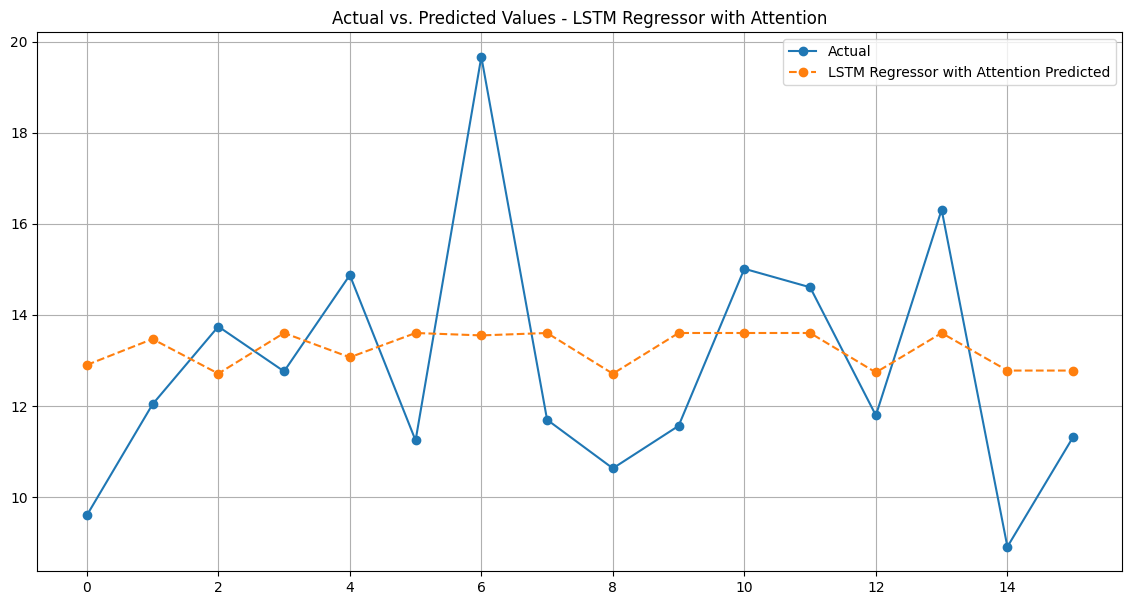


Results For Model: GRU Regressor
Best Hyperparameters: {'batch_size': 20, 'epochs': 50, 'optimizer': 'adam'}
Test RMSE: 2.5313
Test MSE: 6.4073
Test R2: 0.0823
Test MAE: 2.0928


,Actual,Predicted
0,9.60075,12.754677
1,12.03919,13.090642
2,13.74609,12.600180
3,12.76116,13.163975
4,14.87447,12.860205
5,11.24550,13.163975
6,19.66528,13.134664
7,11.69972,13.163975
8,10.63350,12.597095
9,11.56584,13.163975


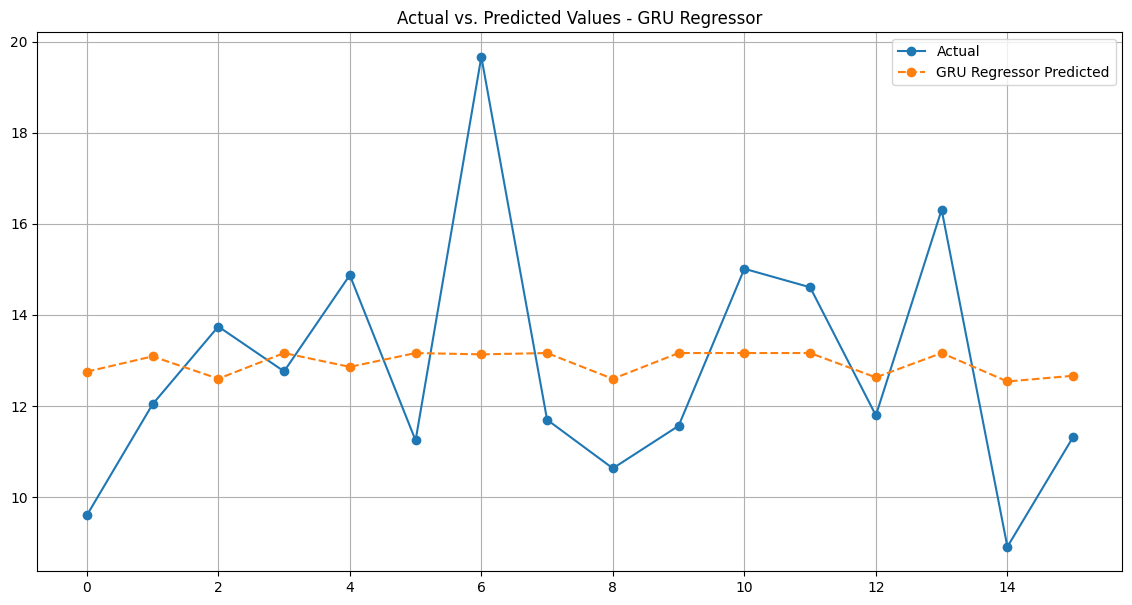


Results For Model: MLP Regressor
Best Hyperparameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 400, 'solver': 'adam'}
Test RMSE: 2.5608
Test MSE: 6.5579
Test R2: 0.0607
Test MAE: 2.0590


,Actual,Predicted
0,9.60075,12.802299
1,12.03919,12.878956
2,13.74609,12.559786
3,12.76116,12.852030
4,14.87447,12.870913
5,11.24550,12.852030
6,19.66528,12.864217
7,11.69972,12.852030
8,10.63350,12.551597
9,11.56584,12.852030


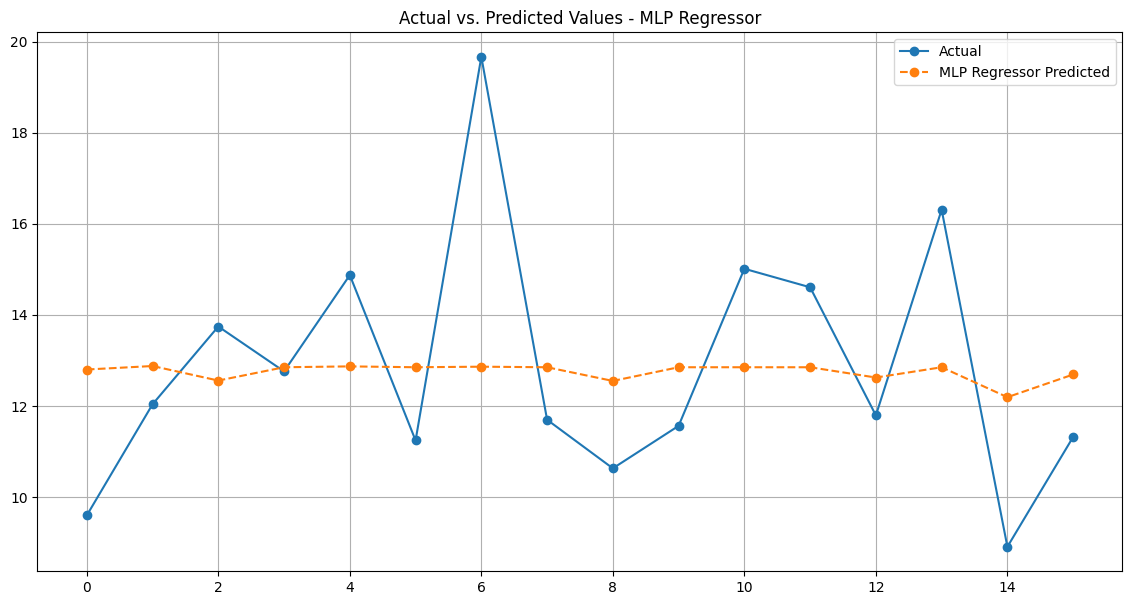


Results For Model: GRU Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 50, 'optimizer': 'rmsprop'}
Test RMSE: 2.6367
Test MSE: 6.9519
Test R2: 0.0043
Test MAE: 2.2334


,Actual,Predicted
0,9.60075,13.305747
1,12.03919,13.464215
2,13.74609,13.222467
3,12.76116,13.496816
4,14.87447,13.357593
5,11.24550,13.496816
6,19.66528,13.483850
7,11.69972,13.496816
8,10.63350,13.220612
9,11.56584,13.496816


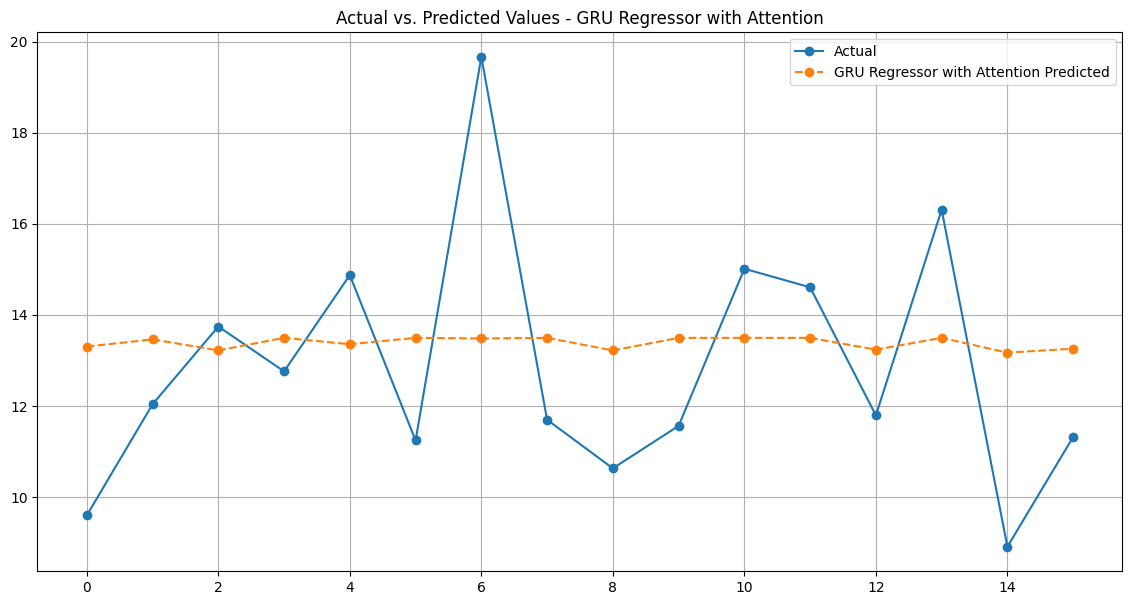


Results For Model: LSTM Regressor
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 2.6403
Test MSE: 6.9712
Test R2: 0.0015
Test MAE: 2.2532


,Actual,Predicted
0,9.60075,13.440669
1,12.03919,13.639379
2,13.74609,13.299594
3,12.76116,13.675955
4,14.87447,13.511199
5,11.24550,13.675955
6,19.66528,13.661510
7,11.69972,13.675955
8,10.63350,13.295656
9,11.56584,13.675955


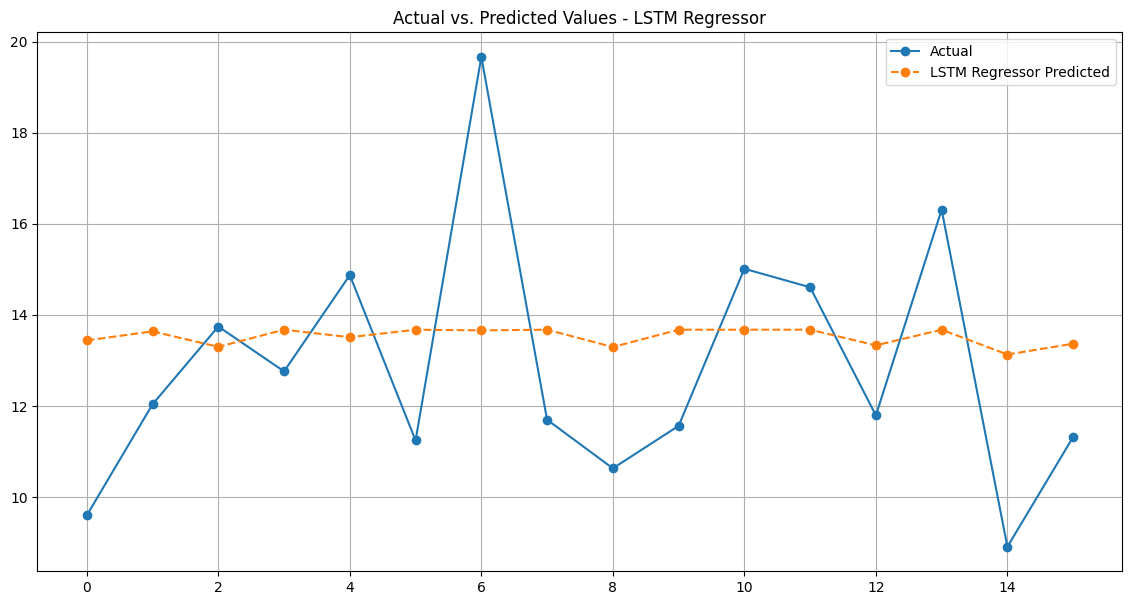


Results For Model: RNN Regressor
Best Hyperparameters: {'batch_size': 10, 'epochs': 50, 'optimizer': 'rmsprop'}
Test RMSE: 2.6613
Test MSE: 7.0827
Test R2: -0.0144
Test MAE: 2.2275


,Actual,Predicted
0,9.60075,13.608170
1,12.03919,13.381274
2,13.74609,13.335779
3,12.76116,13.253976
4,14.87447,13.617975
5,11.24550,13.253976
6,19.66528,13.307280
7,11.69972,13.253976
8,10.63350,13.324401
9,11.56584,13.253976


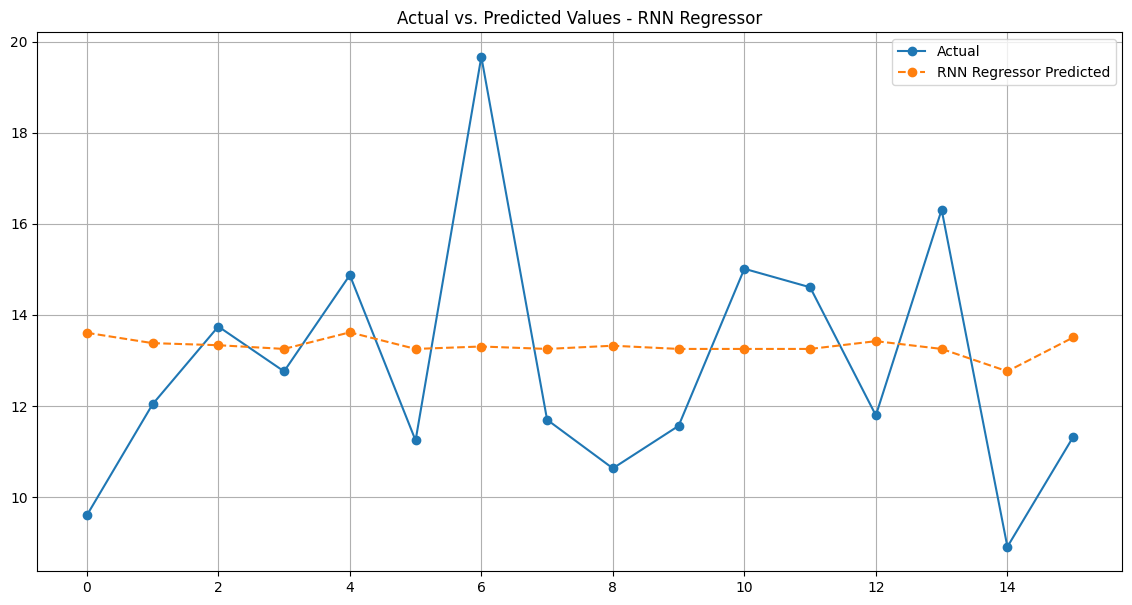


Results For Model: RNN Regressor with Attention
Best Hyperparameters: {'batch_size': 20, 'epochs': 100, 'optimizer': 'rmsprop'}
Test RMSE: 2.7623
Test MSE: 7.6306
Test R2: -0.0929
Test MAE: 2.2939


,Actual,Predicted
0,9.60075,13.564349
1,12.03919,13.328199
2,13.74609,13.599029
3,12.76116,13.259444
4,14.87447,13.506524
5,11.24550,13.259444
6,19.66528,13.287560
7,11.69972,13.259444
8,10.63350,13.598513
9,11.56584,13.259444


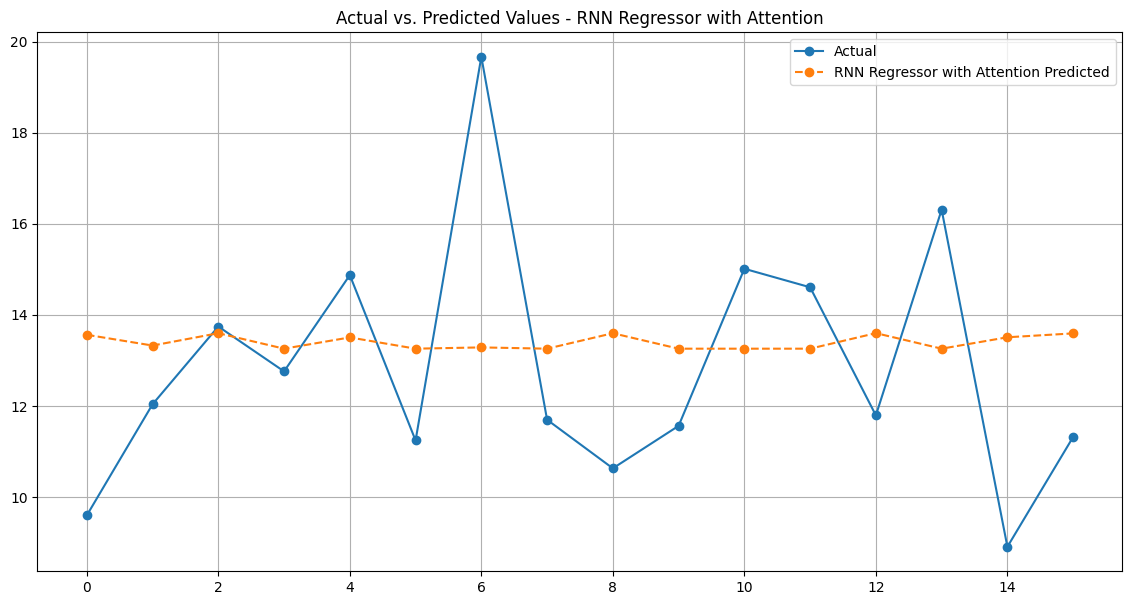


Results For Model: Keras Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 2.8313
Test MSE: 8.0161
Test R2: -0.1481
Test MAE: 2.3334


,Actual,Predicted
0,9.60075,8.522949
1,12.03919,12.737844
2,13.74609,9.770194
3,12.76116,14.078667
4,14.87447,9.246202
5,11.24550,14.078667
6,19.66528,13.545772
7,11.69972,14.078667
8,10.63350,9.794602
9,11.56584,14.078667


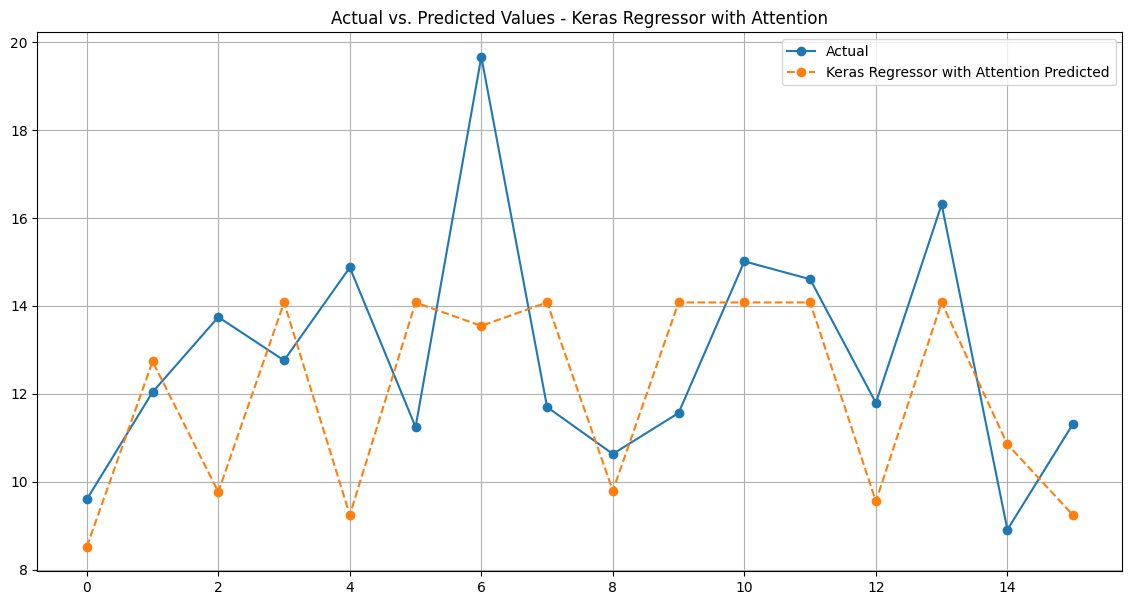


Results For Model: Keras Regressor
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'rmsprop'}
Test RMSE: 3.0425
Test MSE: 9.2566
Test R2: -0.3258
Test MAE: 2.5659


,Actual,Predicted
0,9.60075,7.706346
1,12.03919,12.804674
2,13.74609,9.152813
3,12.76116,14.269129
4,14.87447,8.955116
5,11.24550,14.269129
6,19.66528,13.692222
7,11.69972,14.269129
8,10.63350,9.186192
9,11.56584,14.269129


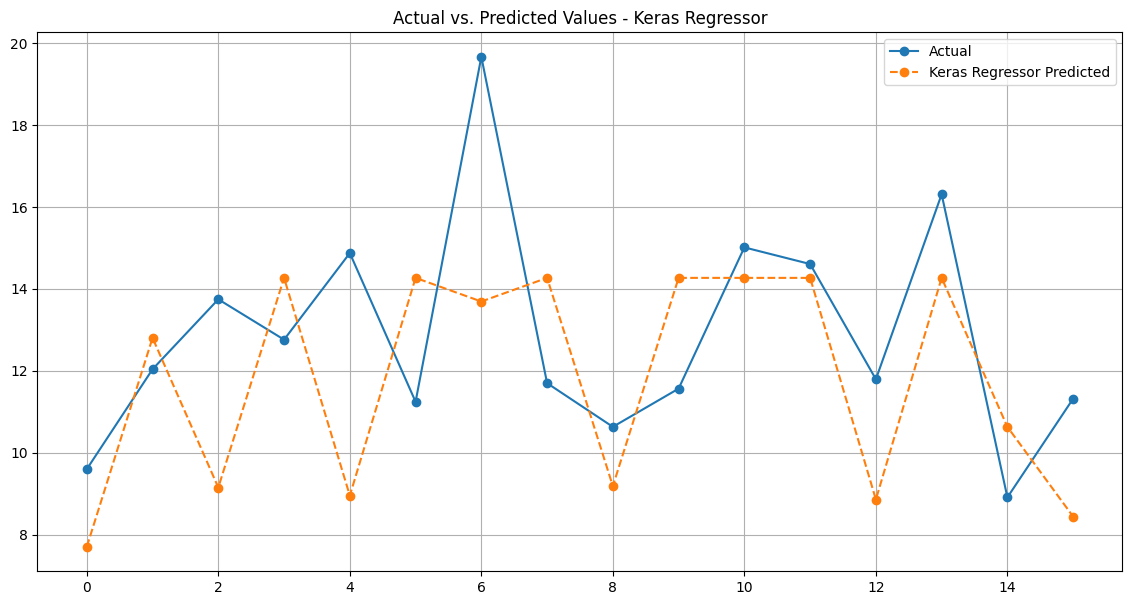


Results For Model: MLP Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 3.1192
Test MSE: 9.7297
Test R2: -0.3935
Test MAE: 2.6434


,Actual,Predicted
0,9.60075,7.430083
1,12.03919,12.889528
2,13.74609,8.963045
3,12.76116,14.311169
4,14.87447,8.828567
5,11.24550,14.311169
6,19.66528,13.732327
7,11.69972,14.311169
8,10.63350,8.999931
9,11.56584,14.311169


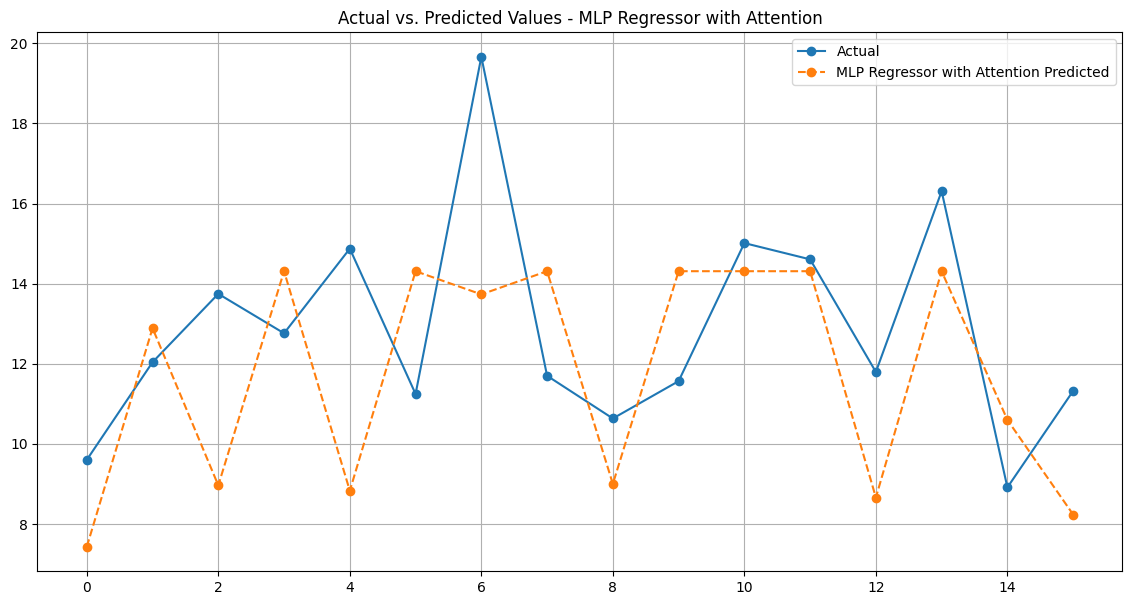

In [19]:
for result in results:
    model_name = result['name']
    print(f"Results For Model: {model_name}")
    print(f"Best Hyperparameters: {result['params']}")
    print(f"Test RMSE: {result['rmse']:.4f}")
    print(f"Test MSE: {result['mse']:.4f}")
    print(f"Test R2: {result['r2']:.4f}")
    print(f"Test MAE: {result['mae']:.4f}")

    comparison_df = result['comparison_df']
    display(comparison_df)

    plt.figure(figsize=(14, 7))
    plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual', marker='o')
    plt.plot(comparison_df.index, comparison_df['Predicted'], label=f'{model_name} Predicted', linestyle='--', marker='o')
    plt.title(f'Actual vs. Predicted Values - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    print()

## Model Evaluation

In [20]:
final_scores_df = pd.DataFrame({
    'Model': [result['name'] for result in results],
    'RMSE': [result['rmse'] for result in results],
    'MSE': [result['mse'] for result in results],
    'R2': [result['r2'] for result in results],
    'MAE': [result['mae'] for result in results]
})

display(final_scores_df)

,Model,RMSE,MSE,R2,MAE
0,LSTM Regressor with Attention,2.516217,6.331350,0.093185,2.143158
1,GRU Regressor,2.531264,6.407296,0.082307,2.092787
2,MLP Regressor,2.560845,6.557925,0.060733,2.058963
3,GRU Regressor with Attention,2.636652,6.951936,0.004301,2.233367
4,LSTM Regressor,2.640310,6.971238,0.001536,2.253225
5,RNN Regressor,2.661343,7.082746,-0.014435,2.227465
6,RNN Regressor with Attention,2.762346,7.630555,-0.092895,2.293872
7,Keras Regressor with Attention,2.831266,8.016070,-0.148111,2.333403
8,Keras Regressor,3.042463,9.256578,-0.325784,2.565857
9,MLP Regressor with Attention,3.119244,9.729684,-0.393546,2.643386
